## EDA for Customer Rentention and Lifetime Value

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import joblib
import shap
from sklearn.inspection import PartialDependenceDisplay

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Customers dataset
customers = pd.read_csv("Customers.csv", index_col=0)
customers.head()

,CustomerID,Age,Gender,Payment Method,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount
0,0,33,Female,Cash,0,24.0,2.0,1,3,0.0,154.139736
1,1,17,Female,Cash,0,28.0,2.0,4,2,3.0,181.432317
2,2,42,Female,Cash,0,15.0,2.0,3,4,0.0,158.854320
3,3,37,Female,Cash,1,1.0,0.0,3,4,0.0,123.408087
4,4,63,Female,Cash,1,0.0,2.0,6,3,0.0,118.313073


In [3]:
customers.describe()

,CustomerID,Age,Churn,Tenure,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,CouponUsed,CashbackAmount
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,43.333280,0.267170,10.772740,2.671030,3.671600,3.028830,1.638740,178.239188
std,28867.657797,15.380321,0.442484,8.784844,1.151747,1.139187,1.320241,1.821813,48.303387
min,0.000000,15.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,106.368742
25%,24999.750000,30.000000,0.000000,1.000000,2.000000,3.000000,2.000000,0.000000,146.323084
50%,49999.500000,43.000000,0.000000,11.000000,3.000000,4.000000,3.000000,1.000000,158.220686
75%,74999.250000,57.000000,1.000000,17.000000,3.000000,4.000000,4.000000,2.000000,203.392564
max,99999.000000,73.000000,1.000000,36.000000,5.000000,6.000000,5.000000,14.000000,324.990000


### Calculating churn rates

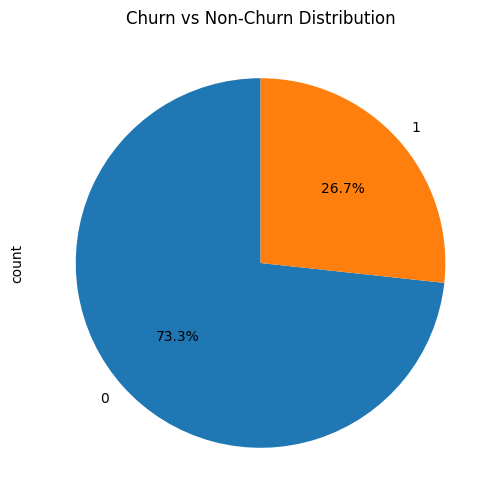

Churn Rate: 26.72%


In [4]:
# Calculate overall churn rates
n_cust = customers.shape[0]

overall_churn_rate = sum(customers['Churn']) * 100 / n_cust 

churn_counts = customers['Churn'].value_counts()
churn_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title('Churn vs Non-Churn Distribution')
plt.show()

print(f"Churn Rate: {overall_churn_rate:.2f}%")

## Data Visualizations

In [5]:
# Mapping Gender for Correlation Matrix
customers['GenderMap'] = customers['Gender'].map({'Male': 1, 'Female': 0})

### Correlation Matrix

Based on the correlation heatmap, it can be observed that variables with highest correlation to Churn is `Tenure`, `CashbackAmount`, `SatisfactionScore` and `NumberOfDeviceRegistered` (in decreasing order). Additionally, `HourSpendOnApp`and `CouponUsed` may also be worth analyzing, as they show some correlation with churn as well.


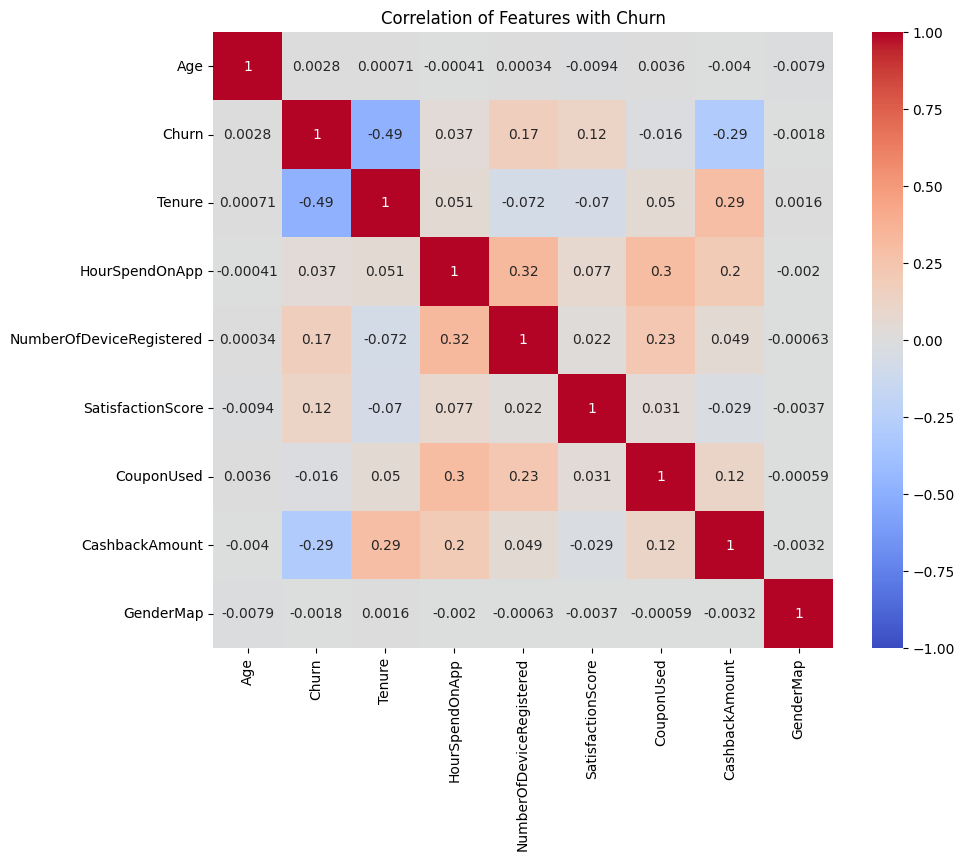

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(customers.drop(['CustomerID'], axis = 1).corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Churn')
plt.show()

### Box Plots

`Tenure` stands out with the most noticeable difference in the median between customers who churned and those who did not, suggesting it's a strong indicator of churn. This is followed by `CashbackAmount` and , where the differences in medians are also quite clear, implying that these features play a role in customer retention.

Meanwhile, the medians of non-churn vs churned customers for `HourSpendOnApp` and `Age` does not seem to have any difference, and might not be useful features for identifying churned customers

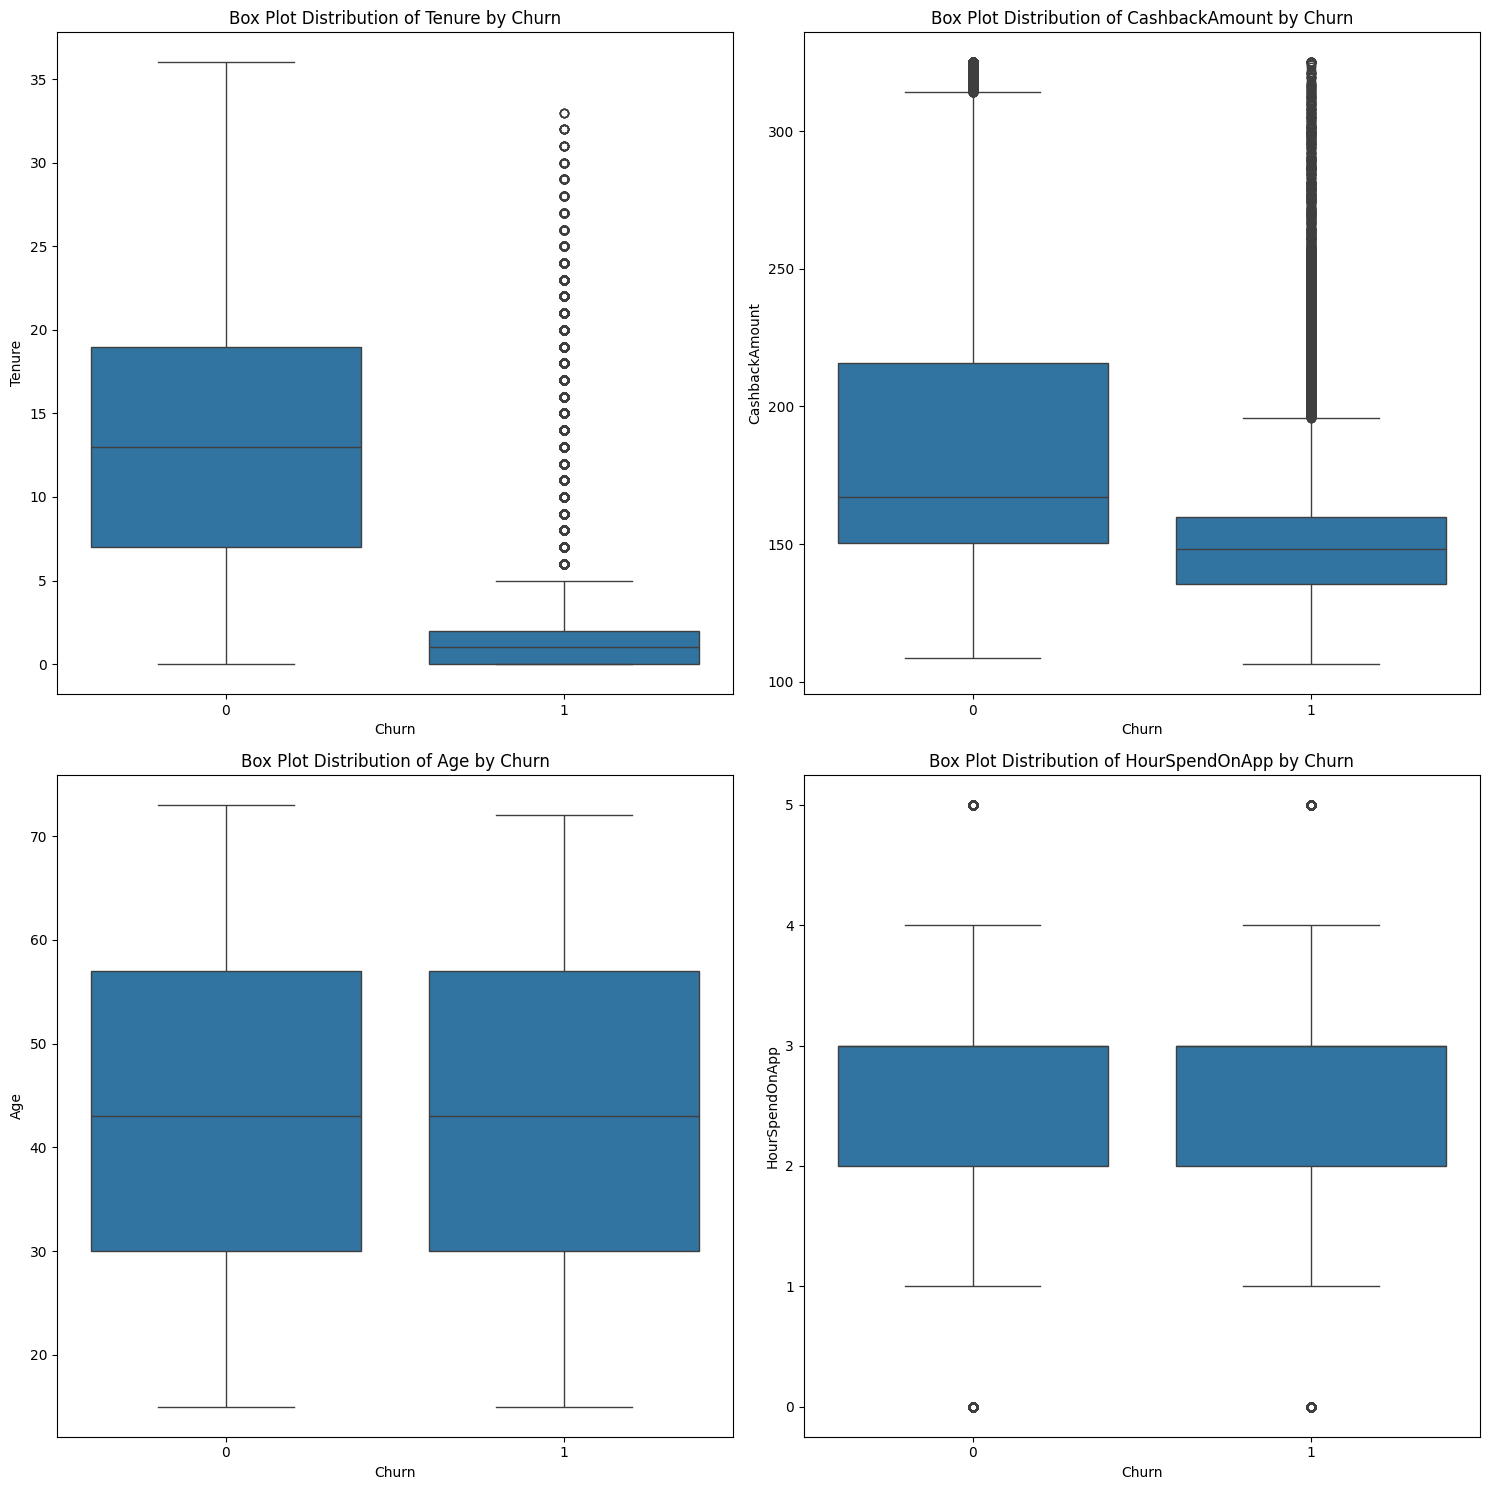

In [7]:
cols = ['Tenure', 'CashbackAmount', 'Age', 'HourSpendOnApp']

plt.figure(figsize=(15, 15))

# For loop to create box plots for each variable in 'numerical_columns'
for i, column in enumerate(cols):
    plt.subplot(2,2, i+1)
    sns.boxplot(x='Churn', y=column, data=customers)
    plt.title(f'Box Plot Distribution of {column} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### KDE Plots

`Tenure` (having the strongest correlation with churn) once again shows a clear pattern. There's a high density of churned customers with tenures between 0 to 3 years, while the distribution for non-churned customers is relatively uniform.

For `HourSpendOnApp`, non-churned customers show higher peaks around 2 to 4 hours, whereas churned customers have a sharp peak at 0 hours, indicating low engagement among those who churned.

`CouponUsed` reveals a distinct pattern, with churned customers showing a significantly higher peak at 1 coupon, and a slightly higher density at 2 coupons compared to non-churned customers.

The `CashbackAmount` distribution shows a very high peak for churned customers around 120-130, while non-churned customers exhibit a more uniform distribution, with a small peak at approximately 150.

As for `Age`, both distributions for churned and non-churning customers are very similar, once again suggesting there is no correlation of age with churn.

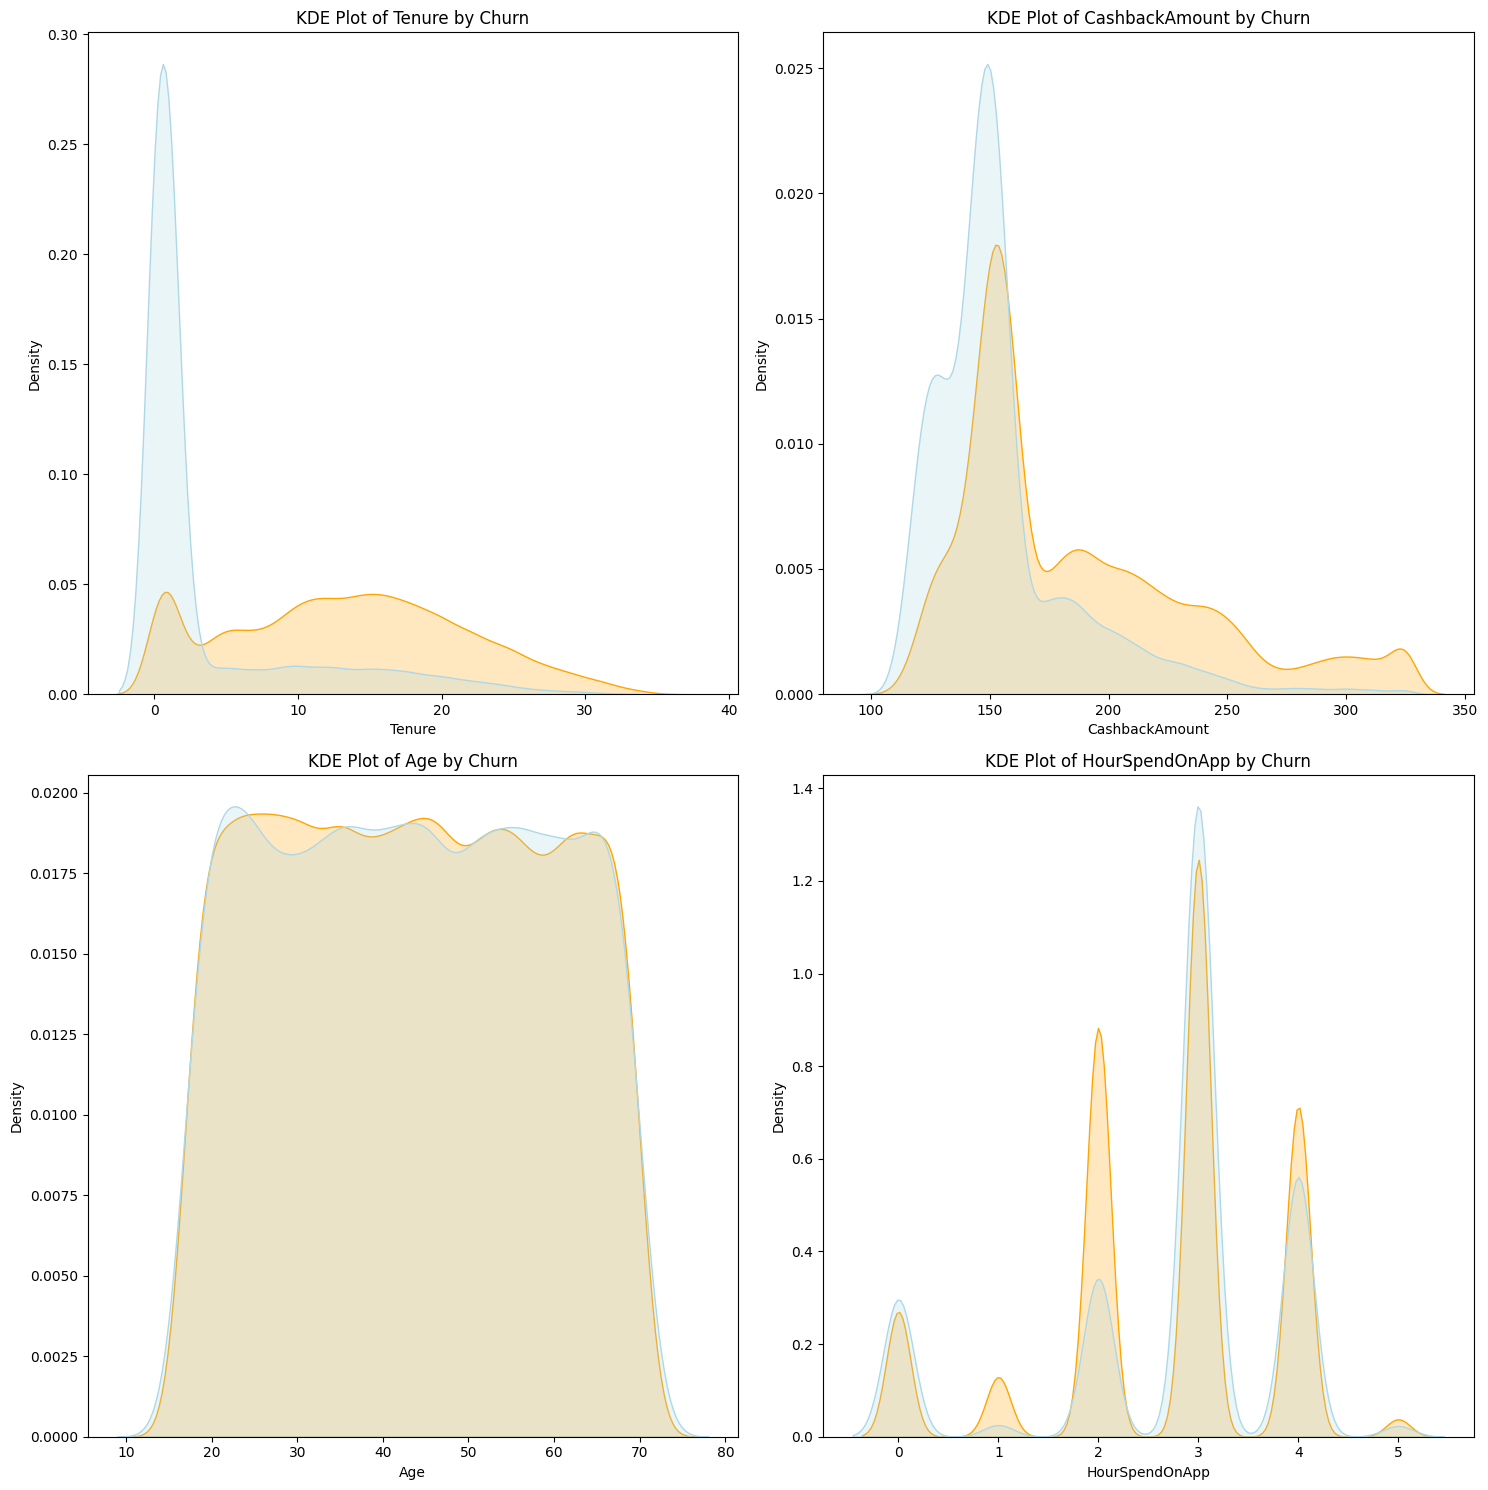

In [8]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(cols):
    ax = plt.subplot(2,2, i+1)
    sns.kdeplot(customers[customers['Churn'] == 0][column], label='Non-Churned', fill=True, ax = ax, color='orange')
    sns.kdeplot(customers[customers['Churn'] == 1][column], label='Churned', fill=True, ax= ax, color='lightblue')
    ax.set_title(f'KDE Plot of {column} by Churn')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

### Bar Plot Distribution (Proportion) by Churn

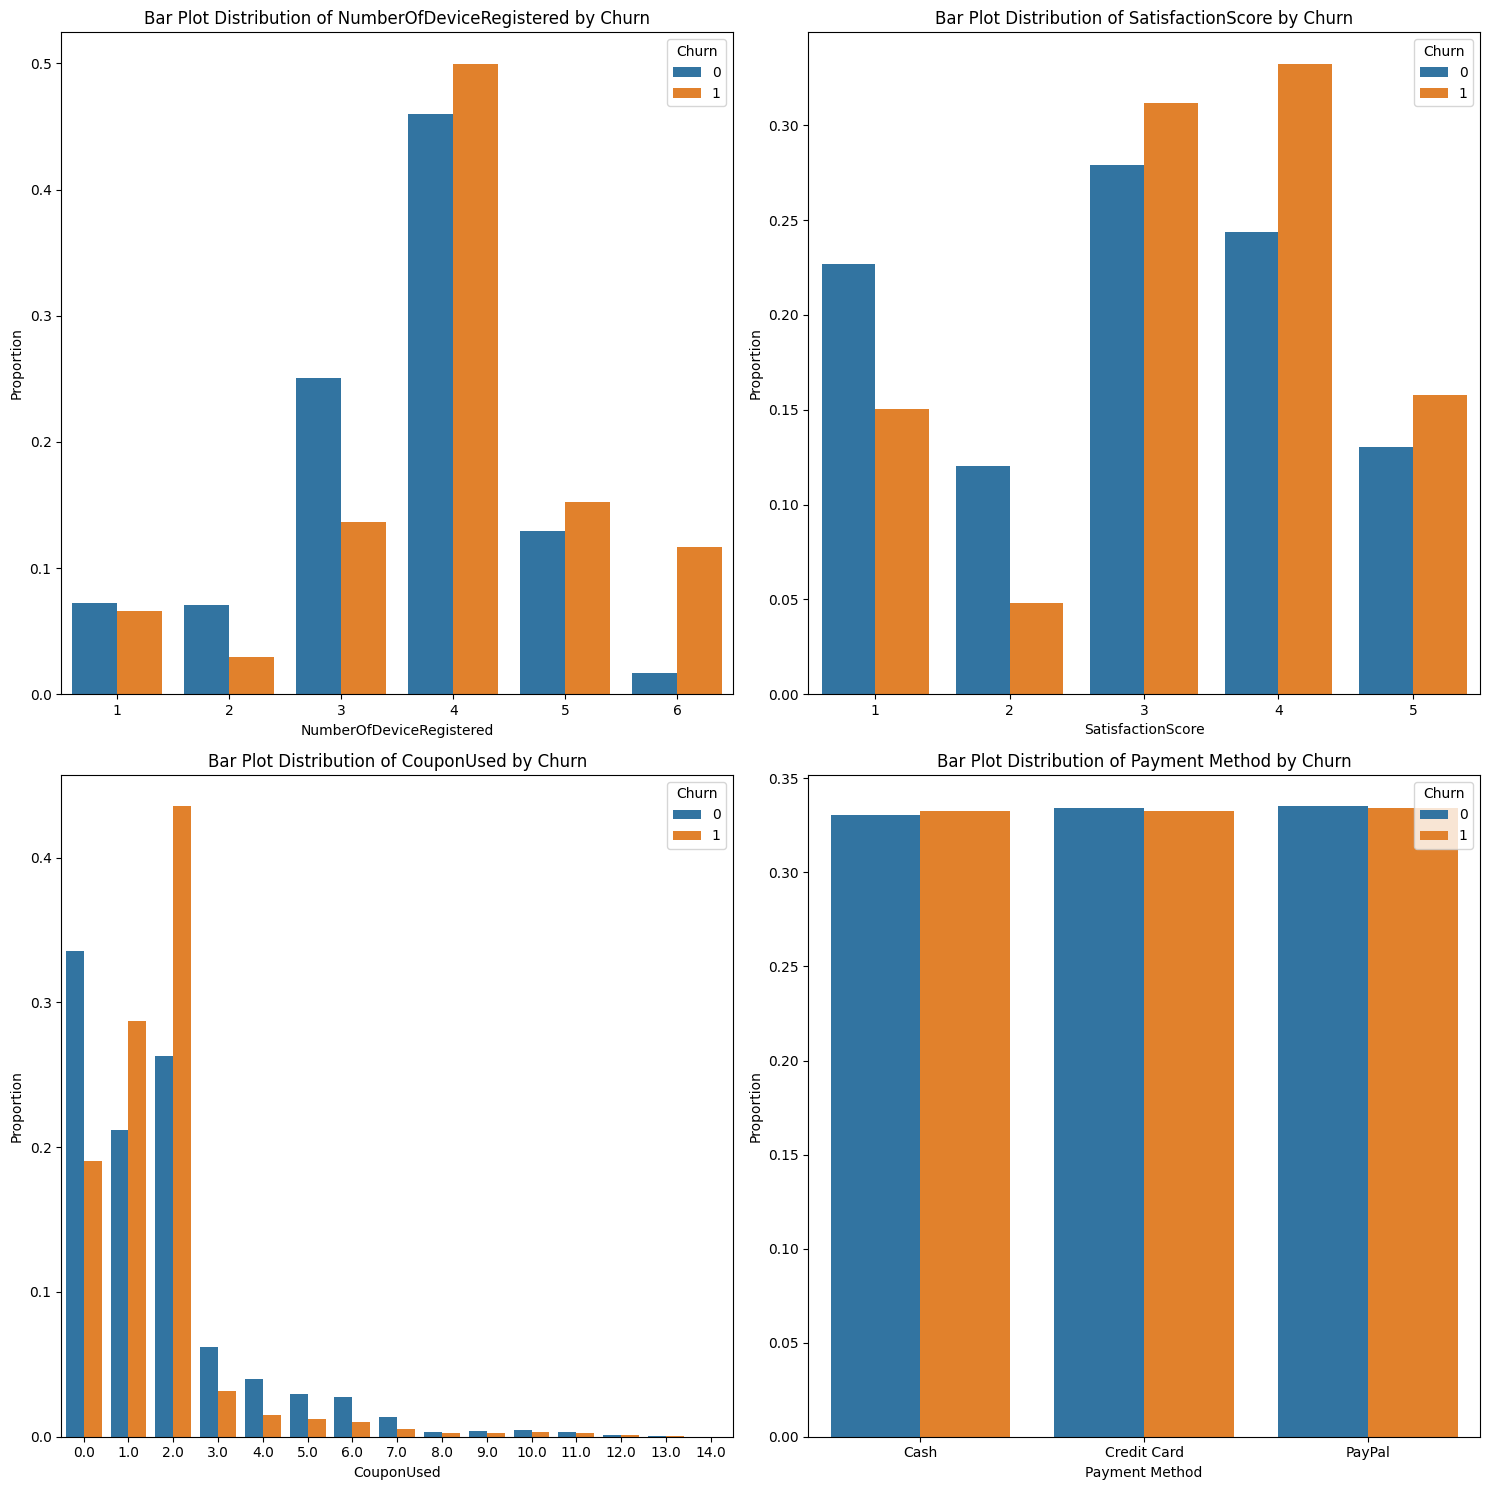

In [9]:
cols = ['NumberOfDeviceRegistered',
       'SatisfactionScore', 'CouponUsed', 'Payment Method']

plt.figure(figsize=(15, 15))

# For loop to create box plots for each variable in 'numerical_columns'
for i, column in enumerate(cols):
    plt.subplot(2,2, i+1)
    
    # Calculate the proportion by churn status for the current column
    churn_proportion = customers.groupby('Churn')[column].value_counts(normalize=True).unstack().fillna(0)
    churn_proportion = churn_proportion.reset_index().melt(id_vars='Churn', var_name=column, value_name='proportion')
    
    sns.barplot(data=churn_proportion, x=column, y='proportion', hue='Churn')
    plt.title(f'Bar Plot Distribution of {column} by Churn')
    plt.xlabel(column)
    plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

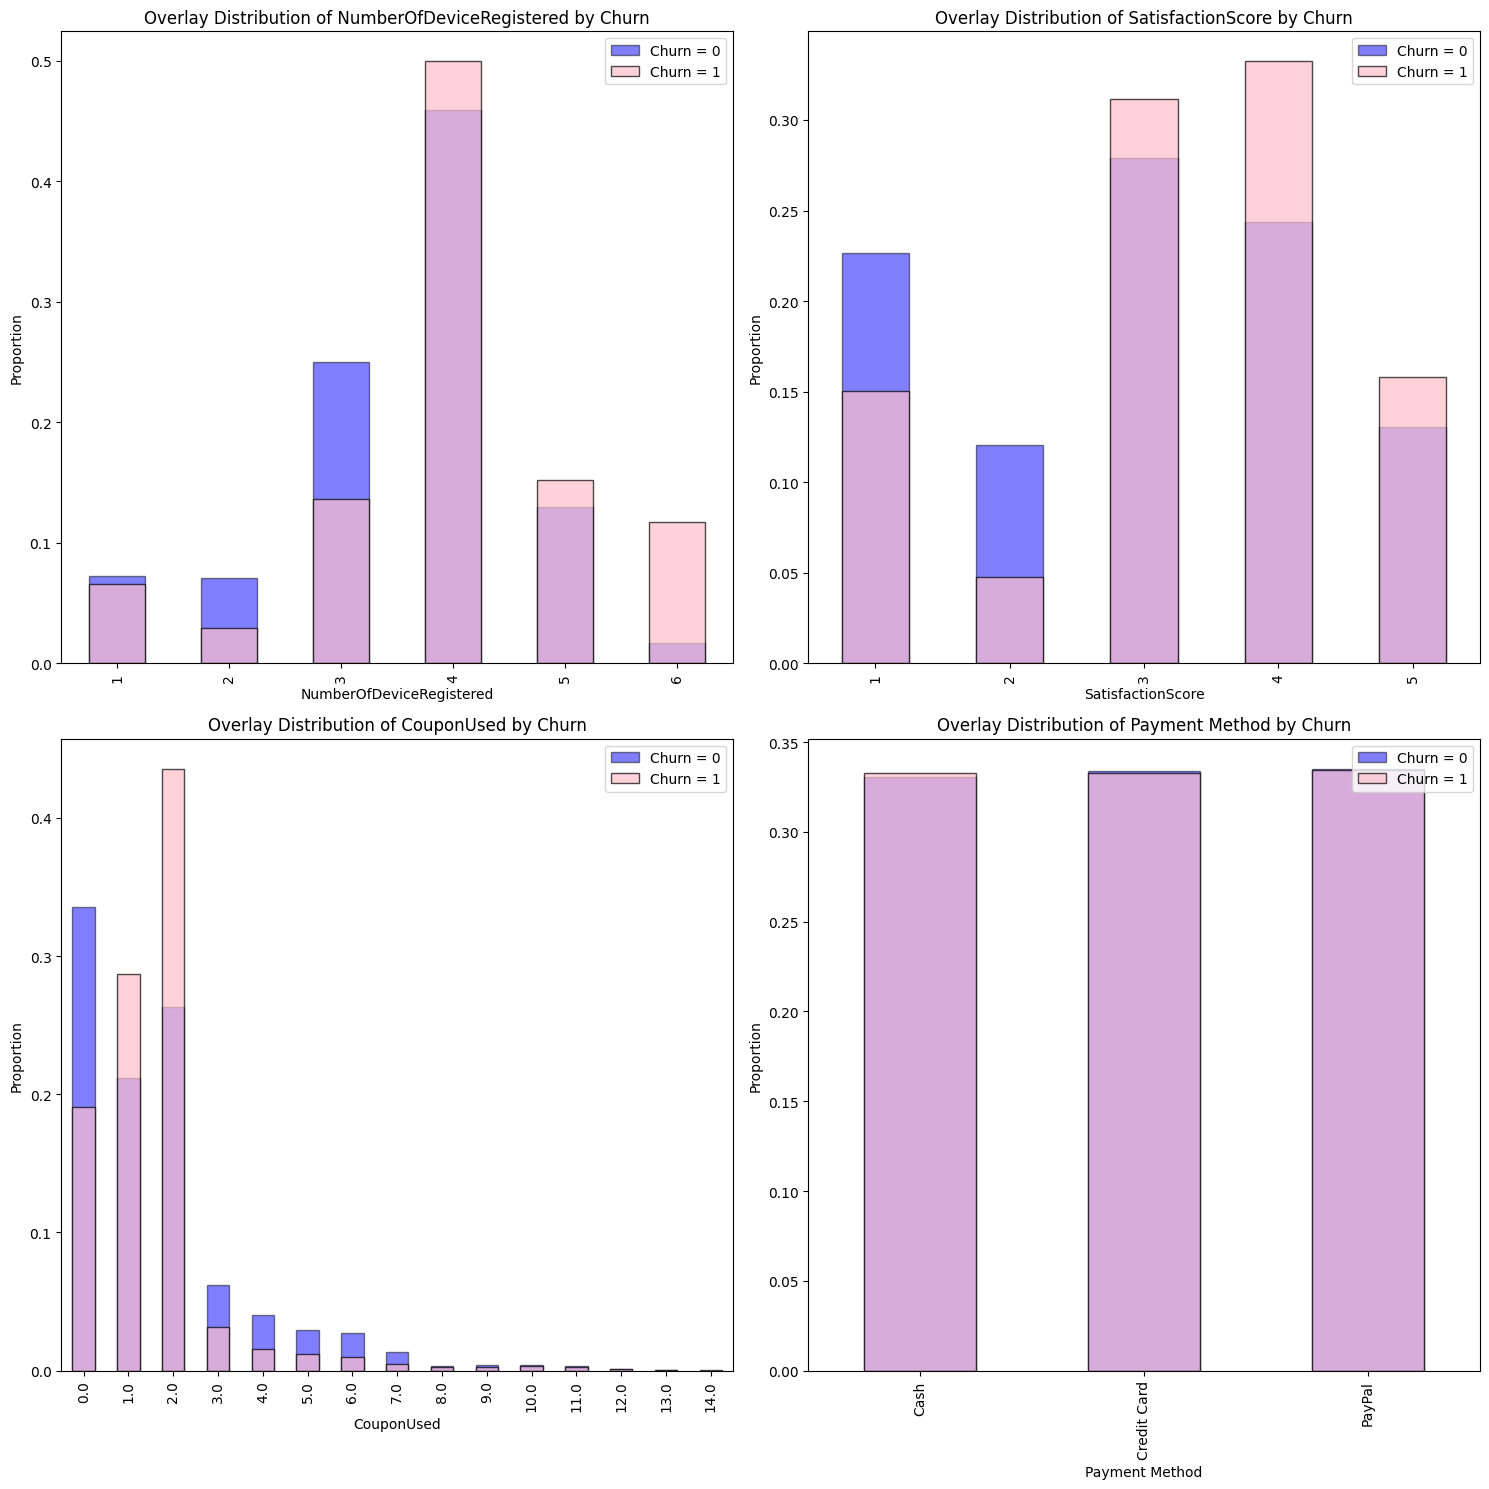

In [10]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(cols):
    plt.subplot(2, 2, i + 1)  
    
    # Calculate proportions
    churn_proportion = customers.groupby('Churn')[column].value_counts(normalize=True).unstack().fillna(0)
    
    # Plot for each churn category
    for churn_value in churn_proportion.index:  # Loop through Churn values (0 and 1)
        churn_proportion.loc[churn_value].plot(
            kind='bar', 
            alpha=0.5 if churn_value == 0 else 0.7,  # Set transparency for overlay effect
            color='b' if churn_value == 0 else 'pink', 
            edgecolor='black', 
            label=f'Churn = {churn_value}', 
            ax=plt.gca()  # Get current subplot
        )
    
    plt.title(f'Overlay Distribution of {column} by Churn')
    plt.xlabel(column)
    plt.ylabel('Proportion')
    plt.legend()

plt.tight_layout()
plt.show()


### Pie Chart of Churn By Gender

From the correlation matrix above, `Gender` has a low correlation with `Churn`. This is supported by the pie charts where the churn rates are similar for both male and female customers

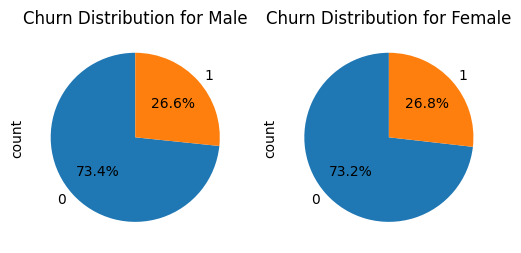

In [11]:
male = customers[customers['Gender'] == 'Male']
female = customers[customers['Gender'] != 'Male']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
male['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title('Churn Distribution for Male')

plt.subplot(1,2,2)
female['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title('Churn Distribution for Female')
plt.show()

## Predictive Modelling 

Now, we will make use of machine learning models to find the features most important for predicting churn and thus characteristics of customers likely to churn, and identify at-risk customers.

In [12]:
customers_encoded = pd.get_dummies(customers, columns=['Payment Method'])

X = customers_encoded.drop(['Churn','Gender', 'CustomerID'], axis = 1)
y = customers_encoded['Churn']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
param_grid = {
    'n_estimators': [300, 400, 500],       # Number of trees in the forest
    'max_depth': [10, 20, 30],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True]            # Whether to bootstrap samples
}

search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=75,
                           cv=5, n_jobs=-1, verbose=1, random_state=42)

search.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=75,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 400, 500]},
                   random_state=42, verbose=1)

In [100]:
# Get and save best model and parameters
joblib.dump(search.best_params_, 'best_params.joblib')
joblib.dump(search.best_estimator_, 'best_rf.joblib')

['best_rf.joblib']

In [14]:
best_params = joblib.load('best_params.joblib')
print("Best Parameters: ", best_params)

Best Parameters:  {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}


In [15]:
# Load best model (Random Forest with the best parameters)
best_rf = joblib.load('best_rf.joblib')

# Predict on the test set using the best model
y_pred = best_rf.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8628
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     14703
           1       0.78      0.68      0.72      5297

    accuracy                           0.86     20000
   macro avg       0.83      0.80      0.82     20000
weighted avg       0.86      0.86      0.86     20000



## Identifying At-Risk Customers

### Using Churn Probabilties

First, identify at-risk customers using churn probabilities from our predictive model:

In [62]:
customers_prob = customers_encoded

customers_prob['Probability'] = best_rf.predict_proba(X)[:, 1]

at_risk = customers_prob[(customers_prob['Churn'] == 0) & (customers_prob['Probability'] > 0.5)]

Next, we will plot bar plots to see the distribution of features for at-risk customers. As seen below: 
- `Age` : Uniform distribution indicates that churn is not age-dependent.
- `Tenure` : Most at-risks customers had tenures of 0 to 1 year, suggesting newer customers are more at risk of churning. Scarcity of customers with tenures longer than 2 years highlights the importance of retaining customers beyond this timeframe to reduce churn.
- `HourSpendOnApp` : High peak at 3 hours.
- `NumberOfDeviceRegistered` : Highest customer counts at 4 devices.
- `SatisfactionScore` : High counts for scores of 3 and 4.
- `CouponUsed` : Highest counts are for customers using 2 coupons, followed closely by those using 1 and 0. This suggests that implementing targeted coupon strategies could be beneficial for retention efforts.
- `CashbackAmount` : Peak at around $150, with diminishing customer counts after $200, implying that specific cashback levels may influence customer satisfaction and retention.

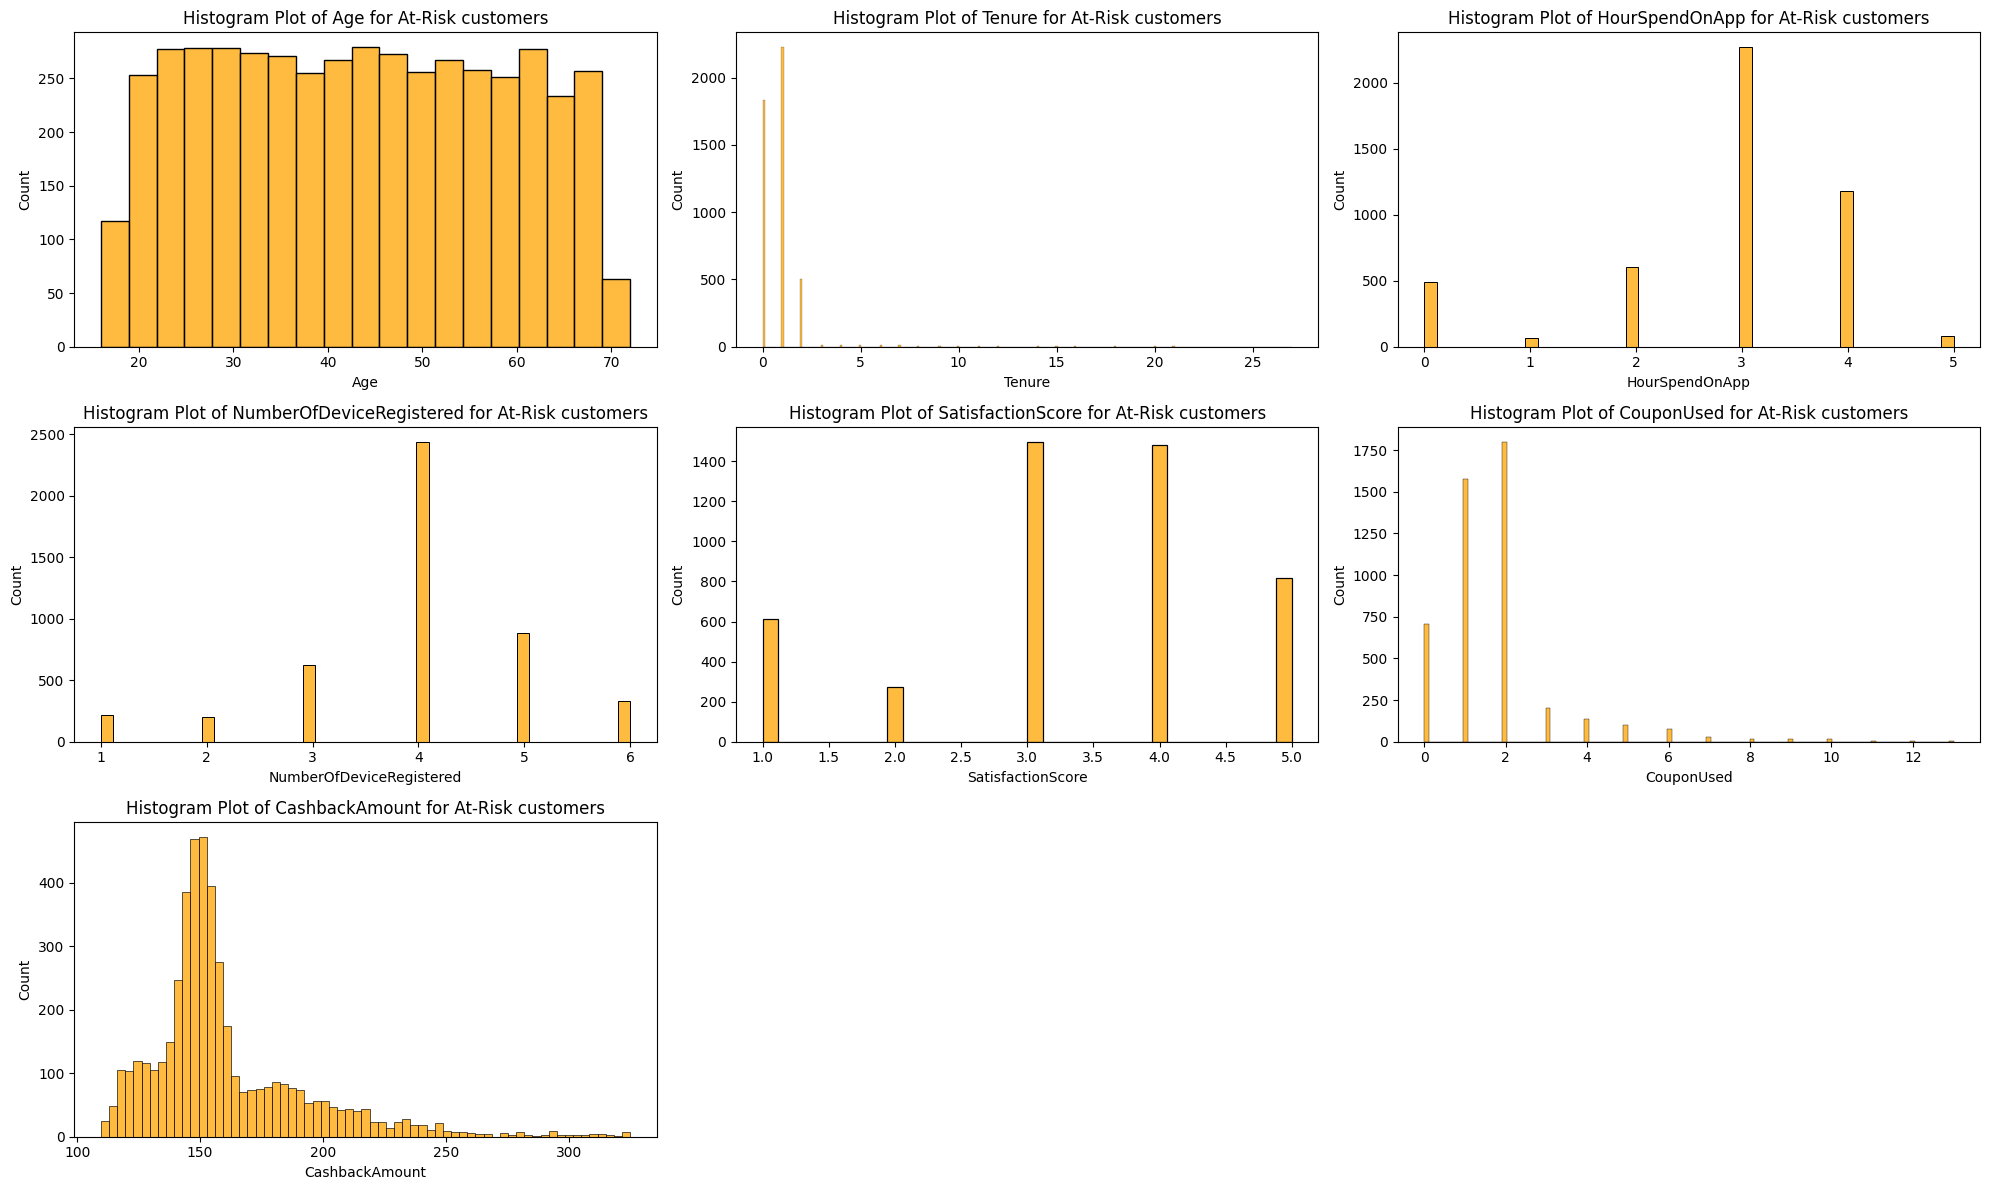

In [65]:
plt.figure(figsize=(20, 12))

cols = ['Age', 'Tenure', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore',
       'CouponUsed','CashbackAmount']

for i, column in enumerate(cols):
    ax = plt.subplot(3,3, i+1)
    sns.histplot(at_risk[column], fill=True, ax = ax, color='orange')
    ax.set_title(f'Histogram Plot of {column} for At-Risk customers')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

### Feature Importance for further analysis

Based on the feature importances from the Random Forest model, `Tenure`, `CashbackAmount`and `NumberOfDeviceRegistered` have the highest importance, aligning with expectations set by the correlation matrix.

`CouponUsed` and `HourSpendOnApp` also surprisingly turned out to be important features for predicting churn.

However, `SatisficationScore` might not have as much importance or correlation as expected from the correlation matrix.

In [ ]:
explainer = shap.TreeExplainer(best_rf)

shap_values = explainer.shap_values(X_test)

# Save shap values for more efficient reproducibility
np.save('shap_values.npy', shap_values)

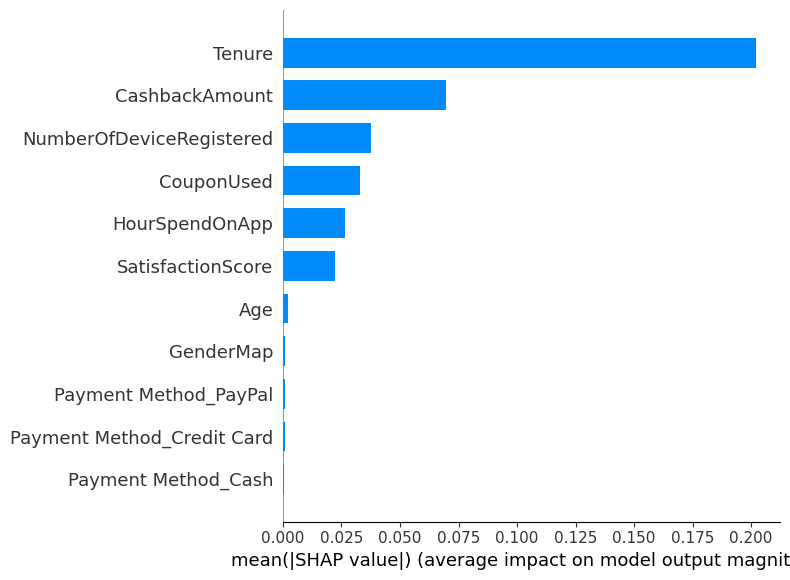

In [ ]:
shap_values = np.load('shap_values.npy')

# This plot shows which features are contributing the most to the model's predictions
shap.summary_plot(shap_values[...,1], X_test, plot_type="bar")

### Deeper Analysis into important features

SHAP (SHapley Additive exPlanations) plots help visualize the impact of each feature on the model's predictions.
Positive SHAP values push the prediction towards 1 (e.g., churn), while negative SHAP values push it towards 0 (e.g., no churn).

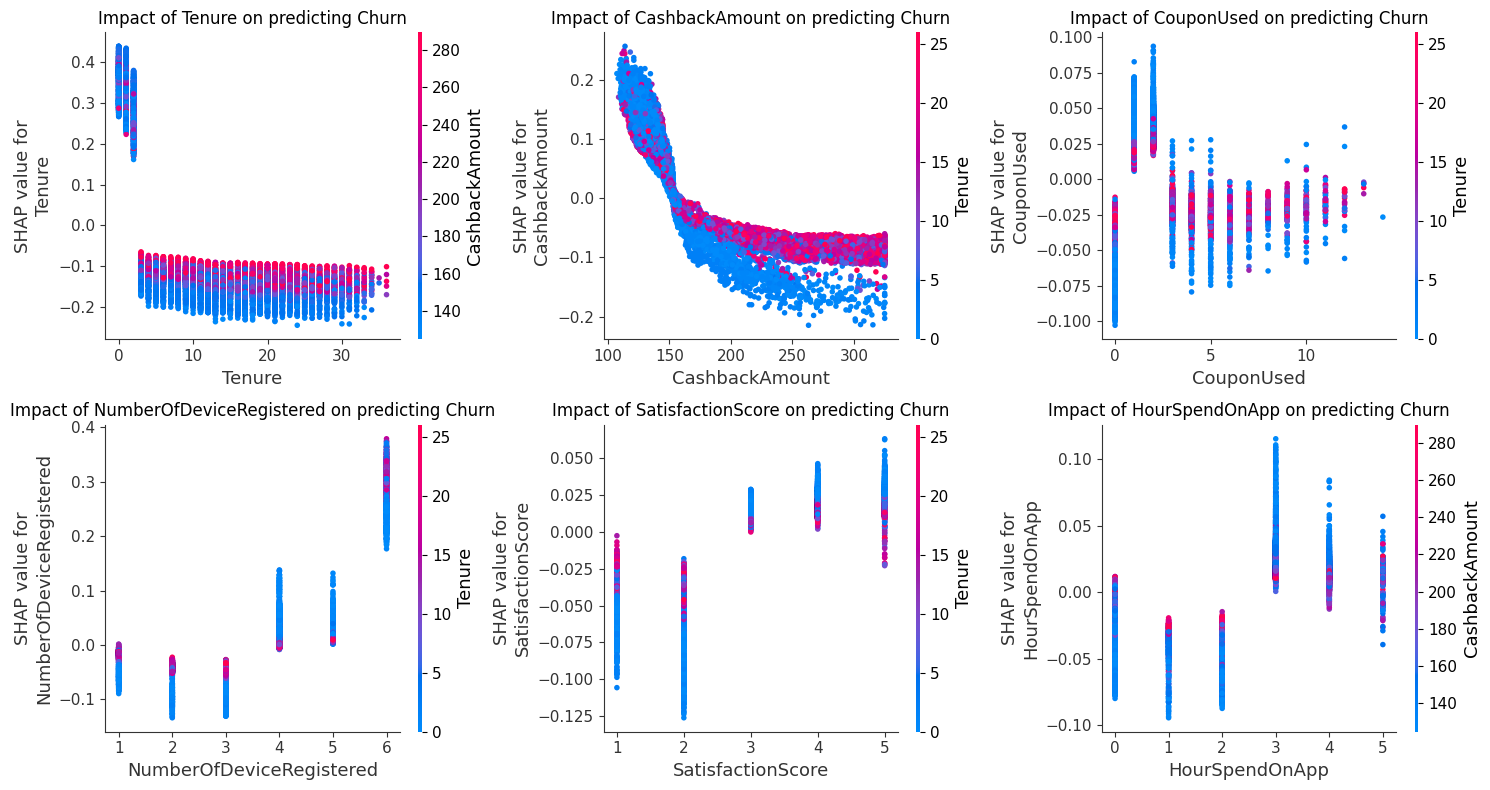

In [34]:
features = ['Tenure', 'CashbackAmount','CouponUsed','NumberOfDeviceRegistered', 'SatisfactionScore', 'HourSpendOnApp']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, column in enumerate(features):
    shap.dependence_plot(column, shap_values[..., 1], X_test, ax=axes[i], show = False)
    axes[i].set_title(f'Impact of {column} on predicting Churn')

plt.tight_layout()
plt.show()

Partial Dependence Plots show the marginal effect of a feature on the predicted outcome of the model, holding all other features constant.
Peaks in PDP show the feature values where the predicted probability/ likeliness of churn is highest.

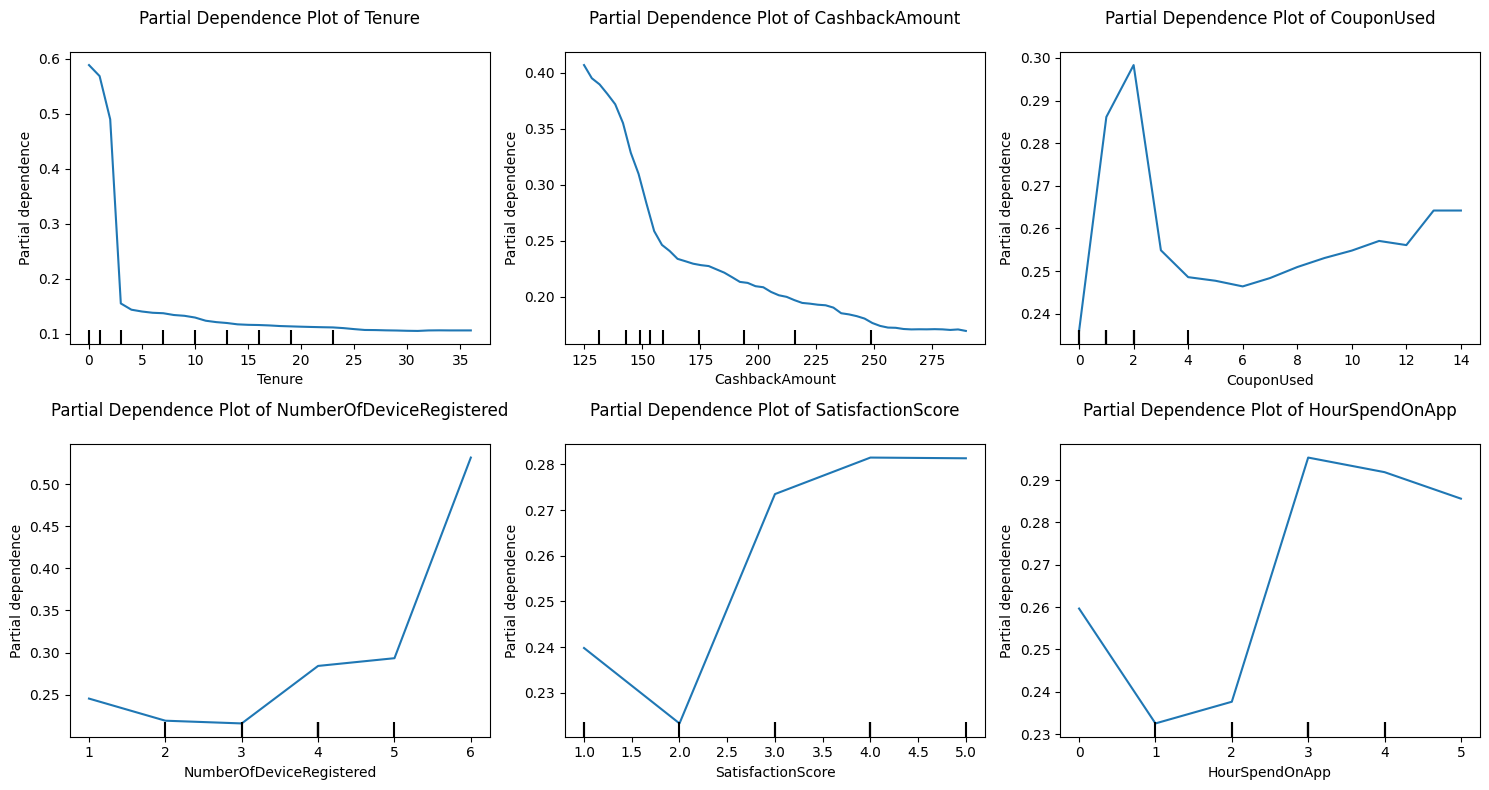

In [35]:
plt.figure(figsize=(15, 8))

for i, column in enumerate(features):
    ax = plt.subplot(2,3, i+1)
    PartialDependenceDisplay.from_estimator(best_rf, X_test, [column], grid_resolution=50, ax=ax)
    ax.set_title(f'Partial Dependence Plot of {column}', pad = 20)

plt.tight_layout()
plt.show()

As such, we can observe that characteristics of customers likely to churn:
- `Tenure` : Less than 3 years.
- `CashbackAmount` : Less than $150.
- `CouponUsed` : 1 to 2.
- `NumberOfDeviceRegistered` : 6.
- `SatisficationScore` : 3 to 5.
- `HourSpendOnApp` : 3 to 5 hours.

This is indeed similar to the features of the at-risk customers identified.

## Analyze current retention strategies

Unfortunately, there isn't sufficient data on current retention strategies for us to delve deeper. However, we can leverage the previous analysis on customer behavior patterns to infer the effectiveness of the possible existing strategies.

Trends among at-risk customers revealed the importance of lengthening customer tenure by 2 years, suggesting current strategies may not adequately address newer customers. Priortising the implemention of early-stage onboarding strategies (tutorials, incentives, welcome discounts etc.) could thus be effective in reducing churn.

Other possible strategies: 

1. Cashback Incentives: Most at-risk customers received around $150 in cashback, with few receiving more than $200. As such, current cashback incentives might not be sufficient or attractive enough to retain customers.
- Introducing more cashback incentives, especially for customers flagged as at-risk of churning, and experimenting with tiered cashback levels (e.g. increasing cashback for higher purchase amounts) might drive customer spending and retention.

2. Coupon Strategies: It's observed that at-risk customers use fewer coupons, with majority utilizing only 1 to 2. This suggests that existing coupon offerings may not be effectively reaching or appealing to these customers. 
- Targeted coupon campaigns (like personalized discount offers based on purchase history) could thus encourage more purchases.

3. Loyalty Program Enhancements: At-risk customers tend to use the app frequently, spending 3–4 hours across multiple devices, with many using 4 devices. This shows that they’re interacting often with the platform, but it is not translating to strong loyalty or satisfaction. Perhaps, there is not enough compelling reasons to make repeat purchases or are experiencing 'app fatigue'—using the app regularly but without sufficient incentive to build loyalty or convert browsing into buying behavior. 
- Some strategies that could be considered: offer points or exclusive rewards or content for frequent app use and repeat purchases, personalized product recommendations, or flash sales accessible only through the platform.

4. Enhancing Customer Engagement: The distribution of satisfaction scores shows a notable number of customers scoring 3 and 4, indicating a moderate level of satisfaction but not sufficient to be a loyal customer.
- Proactive engagement strategies should be developed, perhaps by regular communication through personalized emails, targeted notifications about new offers, or exclusive access to loyalty programs that reward ongoing patronage.
- Furthermore, there's a need to gain more understanding the reasons behind customer scoring 3 and 4 instead of 5. Hence, there could be improvement on the surveys or feedback sessions with at-risk customers.

## AB Testing